In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import expit
from collections import defaultdict

def det_K(x, k1 = 1, k2 = 0.5, k3 = 0.25):
    if x <= 5:
        return k1
    elif x <= 10:
        return k2
    else:
        return k3

filenames = ['newdata/RulevsMCTS_EloData2.csv','newdata/RulevsRule_EloData2.csv','newdata/MCTSvsMCTS_EloData2.csv']

def Elo_Summary(filename, k1 = 1, k2 = 0.5, k3 = 0.25):
    # Read data
    d = pd.read_csv(filename)
    max_games = 20000

    # Shuffle data
    np.random.seed(1234)
    d = d.sample(frac=1).reset_index(drop=True)

    # Get unique strategies
    users = pd.unique(d[['Strategy 1', 'Strategy 2']].values.ravel('K'))
    ratings = dict.fromkeys(users, 1000)
    games = dict.fromkeys(users, 0)

    init_rating1 = np.zeros(len(d))
    init_rating2 = np.zeros(len(d))
    P1_rating = np.zeros(len(d))
    P2_rating = np.zeros(len(d))

    dynamic_ratings = pd.DataFrame(index=np.arange(max_games), columns=users)

    for player in users:
        dynamic_ratings.loc[games[player], player] = ratings[player]

    for i in range(len(d)):
        flag = 0
        s1 = d.loc[i, 'Strategy 1']
        s2 = d.loc[i, 'Strategy 2']
        init_rating1[i] = ratings[s1]
        init_rating2[i] = ratings[s2]

        games[s1] += 1
        games[s2] += 1

        K1 = det_K(games[s1],k1,k2,k3)
        K2 = det_K(games[s2],k1,k2,k3)

        A1 = d.loc[i, 'P1 Score']
        A2 = d.loc[i, 'P2 Score']
        A = A1 + A2
        D = ratings[s1] - ratings[s2]
        I = d.loc[i, 'init.score1'] - d.loc[i, 'init.score2']

        E1 = A / (1 + 10**(0.0029*D - 0.0255*I))
        E2 = A - E1

        if ((A1 - E1) > 0 and d.loc[i, 'Winner_ID'] == 0) or ((A1 - E1) < 0 and d.loc[i, 'Winner_ID'] == 1):
            flag = 1

        if flag == 0:
            ratings[s1] -= round(K1 * (A1 - E1))
            ratings[s2] -= round(K2 * (A2 - E2))

        if games[s1] < max_games:
            dynamic_ratings.loc[games[s1], s1] = ratings[s1]
        if games[s2] < max_games:
            dynamic_ratings.loc[games[s2], s2] = ratings[s2]

        P1_rating[i] = ratings[s1]
        P2_rating[i] = ratings[s2]

    d['P1_rating'] = P1_rating
    d['P2_rating'] = P2_rating
    d['init.rating1'] = init_rating1
    d['init.rating2'] = init_rating2

    dynamic_ratings.index.name = 'Games'
    dynamic_ratings = dynamic_ratings.astype('float')

    return dynamic_ratings, ratings, d

In [3]:
dynamic_ratings, ratings, d = Elo_Summary(filenames[0])

In [4]:
ratings

{'Mindist + Opp': 1126, 'mcts-50': 992, 'mcts-25': 946, 'mcts-10': 913}

In [5]:
d.head()

,init.score1,init.score2,Strategy 1,Strategy 2,P1 Score,P2 Score,Winner_ID,P1_rating,P2_rating,init.rating1,init.rating2
0,52,49,Mindist + Opp,mcts-10,0,32,0,1017.0,983.0,1000.0,1000.0
1,28,42,Mindist + Opp,mcts-10,0,10,0,1020.0,980.0,1017.0,983.0
2,33,58,mcts-50,Mindist + Opp,36,0,1,972.0,1048.0,1000.0,1020.0
3,43,40,mcts-25,Mindist + Opp,40,0,1,985.0,1063.0,1000.0,1048.0
4,43,27,mcts-10,Mindist + Opp,25,0,1,975.0,1068.0,980.0,1063.0


In [6]:
dynamic_ratings.head()

,Mindist + Opp,mcts-50,mcts-25,mcts-10
Games,,,,
0,1000.0,1000.0,1000.0,1000.0
1,1017.0,972.0,985.0,983.0
2,1020.0,974.0,975.0,980.0
3,1048.0,967.0,972.0,975.0
4,1063.0,938.0,970.0,985.0


In [7]:
# Moving average
window = 3000
df_long = dynamic_ratings.reset_index().melt(id_vars='Games', var_name='Series', value_name='Value')
df_long['Moving_Avg'] = df_long.groupby('Series')['Value'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean()
)
# df_long.head() df_long.tail()

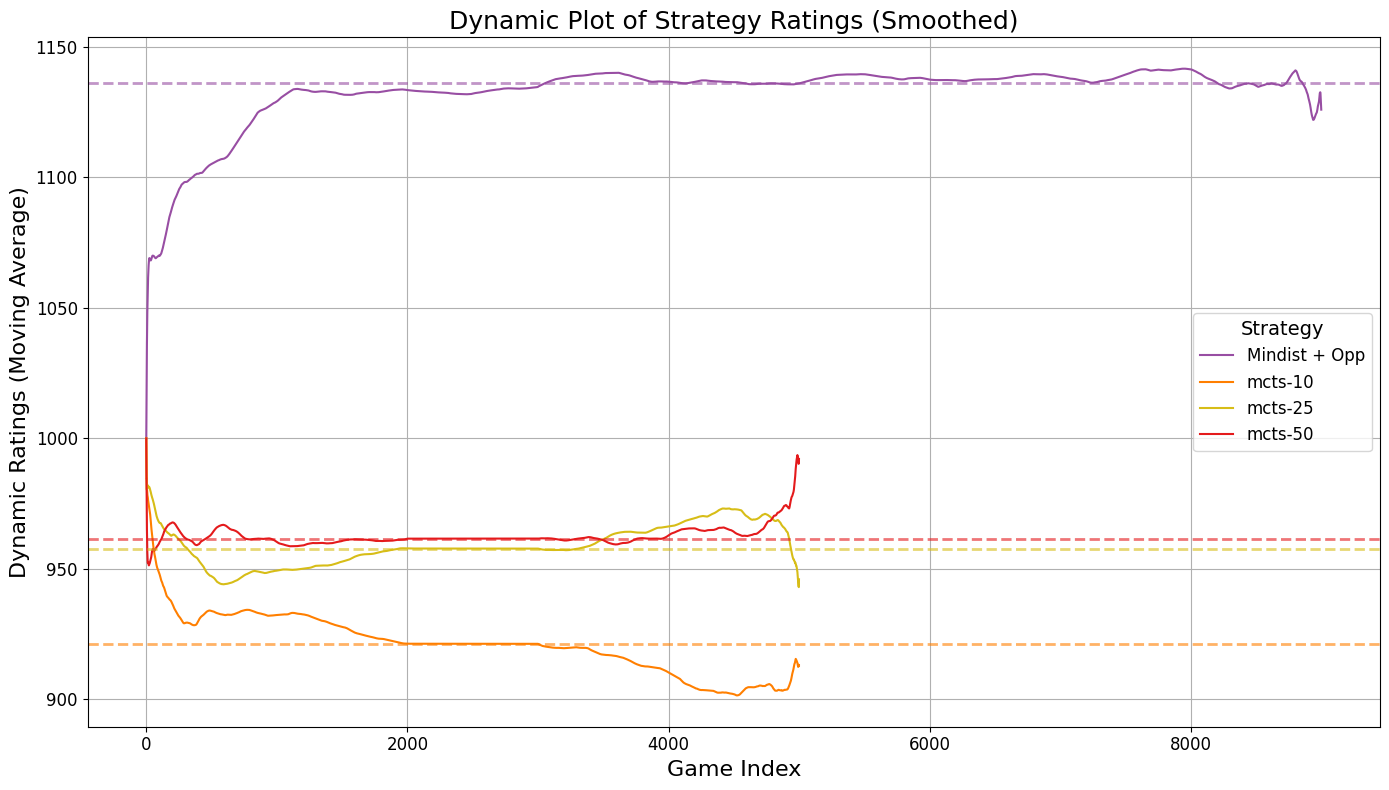

In [8]:
# Average lines
avg_lines = df_long.groupby('Series')['Value'].mean().reset_index()
avg_lines.columns = ['Series', 'Average']

# Plot
plt.figure(figsize=(14, 8))
main_colors = {
    "Mindist": "#e41a1c",
    "Random": "#377eb8",
    "Minscore": "#4daf4a",
    "Mindist + Opp": "#984ea3",
    "Mindist + minscore": "#ff7f00",
    "Defeat Heuristic": "#d7bd17",
    "mcts-0": "#377eb8",
    "mcts-50": "#e41a1c",
    "mcts-25": "#d7bd17",
    "mcts-10": "#ff7f00",
}
for name, group in df_long.groupby('Series'):
    if name in main_colors:
        plt.plot(group['Games'], group['Moving_Avg'], label=name, color=main_colors[name], linewidth=1.5)

for _, row in avg_lines.iterrows():
    if row['Series'] in main_colors:
        plt.axhline(y=row['Average'], color=main_colors[row['Series']], linestyle='--', alpha=0.6, linewidth=2)

plt.title('Dynamic Plot of Strategy Ratings (Smoothed)', fontsize=18)
plt.xlabel('Game Index', fontsize=16)
plt.ylabel('Dynamic Ratings (Moving Average)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Strategy', fontsize=12, title_fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import tqdm

k_values =[
(-1.8, -1, -0.5),
(-1.8, -1.25, -0.5),
(-1.5,-1.25,-0.5),
(-1.5, -1, -0.5),
(-1.25, -0.75, -0.5),
(-1,-0.75,-0.5),
(-1.8,-1.25,-0.75),
(-1.8,-1,-0.75),
(-1.5,-1.25,-0.75),
(-1.5,-1,-0.75),
(-1.25,-1,-0.75),
(-1.8,-1.5,-1),
(-1.8,-1.25,-1),
(-1.8,-1.5,-1.25)]

accuracy_scores = {}

for k1,k2,k3 in tqdm.tqdm(k_values):
    k1 = -k1
    k2 = -k2
    k3 = -k3
    total = pd.DataFrame()
    for i, filename in enumerate(filenames):
        dynamic_ratings, ratings, d = Elo_Summary(filename,k1,k2,k3)
        # print(f"({k1},{k2},{k3}): file {filename}\n   final rating: {ratings}")
        if i == 0 :
            total = d
        else:
            total = pd.concat([total,d])
    X = total[['P1_rating', 'P2_rating']]  # predictors
    y = total['Winner_ID']  # binary target

    # Split data
    n = 10
    accuracy_scores[(k1,k2,k3)] = 0
    for j in range(n): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # Logistic regression model
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluation
        # accuracy_scores[(k1,k2,k3)] = round(accuracy_score(y_test, y_pred)*100,3)
        c_m =confusion_matrix(y_test, y_pred)
        precision = c_m[1,1]/(c_m[0,1]+c_m[1,1])
        recall = c_m[1,1]/(c_m[1,0]+c_m[1,1])
        accuracy_scores[(k1,k2,k3)] += 2/(1/precision +1/recall)
        # print(confusion_matrix(y_test, y_pred))
    accuracy_scores[(k1,k2,k3)] /= n

100%|██████████| 14/14 [03:26<00:00, 14.73s/it]


In [11]:
print("K values             F1 Scores    Norm")
new_dict = {}
for K, f1_score in sorted(accuracy_scores.items(), key=lambda x: -x[1]):
    print(f"{str(K):<18} | {f1_score:>8.3f} | {np.linalg.norm(K):>7.3f}")
    new_dict[np.linalg.norm(K)] = f1_score,K

K values             F1 Scores    Norm
(1.8, 1.5, 1.25)   |    0.796 |   2.656
(1.8, 1.5, 1)      |    0.789 |   2.548
(1.8, 1.25, 1)     |    0.789 |   2.409
(1.25, 1, 0.75)    |    0.780 |   1.768
(1.5, 1, 0.75)     |    0.780 |   1.953
(1.8, 1.25, 0.75)  |    0.779 |   2.316
(1.5, 1.25, 0.75)  |    0.779 |   2.092
(1.8, 1, 0.75)     |    0.779 |   2.191
(1.5, 1.25, 0.5)   |    0.769 |   2.016
(1, 0.75, 0.5)     |    0.769 |   1.346
(1.8, 1, 0.5)      |    0.769 |   2.119
(1.8, 1.25, 0.5)   |    0.769 |   2.248
(1.5, 1, 0.5)      |    0.769 |   1.871
(1.25, 0.75, 0.5)  |    0.769 |   1.541


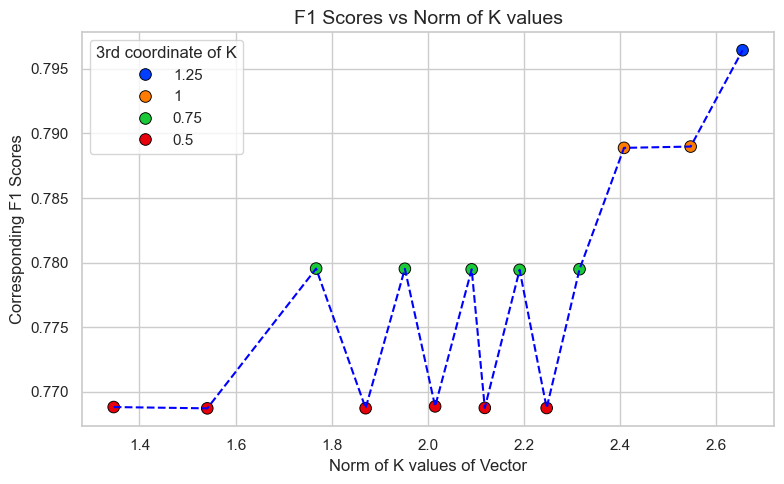

In [19]:
# Create a DataFrame for Seaborn
df = pd.DataFrame([
    {
        'Norm of K values': norm,
        'F1 Scores': val[0],
        'K3': str(val[1][2])  # Convert K to string for categorical hue
    }
    for norm, val in new_dict.items()
])

# Set Seaborn style
sns.set(style="whitegrid", context="notebook")

# Create the scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Norm of K values', y='F1 Scores', s=70, hue='K3', edgecolor='black', palette="bright")
sns.lineplot(data=df.sort_values('Norm of K values'), x='Norm of K values', y='F1 Scores', color='blue', linestyle='--')

plt.title("F1 Scores vs Norm of K values", fontsize=14)
plt.legend(title="3rd coordinate of K")
plt.xlabel("Norm of K values of Vector")
plt.ylabel("Corresponding F1 Scores")
plt.tight_layout()
plt.show()